In [1]:
!subst N: E:\Network_Data_Sync
!subst S: E:\Network_Data_Sync
!subst O: "E:\OneDrive - Washington University in St. Louis"

Drive already SUBSTed
Drive already SUBSTed
Drive already SUBSTed


In [2]:
# reload the libs as we edit them
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
from GAN_utils import upconvGAN
from torchvision import models
import numpy as np
from scipy.io import loadmat
from os.path import join
from sklearn.decomposition import NMF
import matplotlib.pylab as plt
from numpy.linalg import norm as npnorm
from data_loader import load_score_mat, loadmat, mat_path, join
from CorrFeatTsr_lib import visualize_cctsr, visualize_cctsr_embed, Corr_Feat_Machine, Corr_Feat_pipeline, loadimg_preprocess, loadimg_embed_preprocess
from tqdm import tqdm
from CorrFeatTsr_visualize import CorrFeatScore, corr_GAN_visualize, preprocess
def show_img(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()

def rectify_tsr(Ttsr, mode="abs", thr=(-5, 5)):
    if mode is "pos_rect":
        Ttsr_pp = np.clip(Ttsr, 0, None)
    elif mode is "abs":
        Ttsr_pp = np.abs(Ttsr)
    elif mode is "thresh":
        Ttsr_pp = Ttsr.copy()
        Ttsr_pp[(Ttsr<thr[1])*(Ttsr>thr[0])] = 0
        Ttsr_pp = np.abs(Ttsr_pp)
    else:
        raise ValueError
    return Ttsr_pp

def tsr_factorize(Ttsr_pp, cctsr, bdr=2, Nfactor=3):
    C, H, W = Ttsr_pp.shape
    if bdr == 0:
        Tmat = Ttsr_pp.reshape(C, H*W)
        ccmat = cctsr.reshape(C, H*W)
    else:
        Tmat = Ttsr_pp[:, bdr:-bdr, bdr:-bdr].reshape(C, (H-2*bdr)*(W-2*bdr))
        ccmat = cctsr[:, bdr:-bdr, bdr:-bdr].reshape(C, (H-2*bdr)*(W-2*bdr))
    #%
    nmfsolver = NMF(n_components=Nfactor, init="nndsvda", solver="cd")#mu
    Hmat = nmfsolver.fit_transform(Tmat.T)
    Hmaps = Hmat.reshape([H-2*bdr, W-2*bdr, Nfactor])
    exp_var = 1-npnorm(Tmat.T-Hmat@nmfsolver.components_)/npnorm(Tmat)
    print("NMF explained variance %.3f"%exp_var)
    ccfactor = (ccmat @ np.linalg.pinv(Hmat).T )
    # ccfactor = (ccmat @ Hmat )
    reg_cc = np.corrcoef((ccfactor@Hmat.T).flatten(), ccmat.flatten())[0,1]
    print("Predictability of the corr coef tensor %.3f"%reg_cc)

    plt.imshow(Hmaps[:,:,:3] / Hmaps[:,:,:3].max())
    plt.title("channel merged")
    plt.show()
    [figh, axs] = plt.subplots(1,Nfactor,figsize=[Nfactor*2.7, 2.5])
    for ci in range(Hmaps.shape[2]):
        plt.sca(axs[ci])
        plt.imshow(Hmaps[:,:,ci] / Hmaps.max())
        plt.axis("off")
        plt.colorbar()
    plt.suptitle("Separate Factors")
    plt.show()
    featvecs = nmfsolver.components_
    fact_norms = []
    for i in range(Hmaps.shape[2]):
        rank1_mat = Hmat[:, i:i+1]@featvecs[i:i+1, :]
        matnorm = npnorm(rank1_mat, ord="fro")
        fact_norms.append(matnorm)
        print("Factor%d norm %.2f"%(i, matnorm))
    return Hmat, Hmaps, nmfsolver.components_, ccfactor

In [13]:
Animal = "Alfa"
Expi = 3
MStats = loadmat(join(mat_path, Animal + "_Manif_stats.mat"), struct_as_record=False, squeeze_me=True)['Stats']
EStats = loadmat(join(mat_path, Animal + "_Evol_stats.mat"), struct_as_record=False, squeeze_me=True, chars_as_strings=True)['EStats']
score_vect, imgfullpath_vect = load_score_mat(EStats, MStats, Expi, "Manif_avg", wdws=[(50, 200)], stimdrive="S")#Manif_avg

In [14]:
corrDict = np.load(join("S:\corrFeatTsr","%s_Exp%d_Evol_nobdr_corrTsr.npz"%(Animal,Expi)), allow_pickle=True)
cctsr_dict = corrDict.get("cctsr").item()
Ttsr_dict = corrDict.get("Ttsr").item()

NMF explained variance 0.519
Predictability of the corr coef tensor 0.527
Factor0 norm 1139.00
Factor1 norm 1398.58
Factor2 norm 1374.70
Factor3 norm 1579.74
Factor4 norm 1441.95


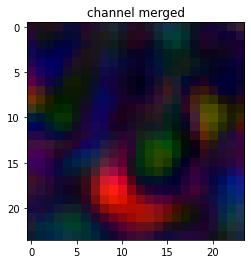

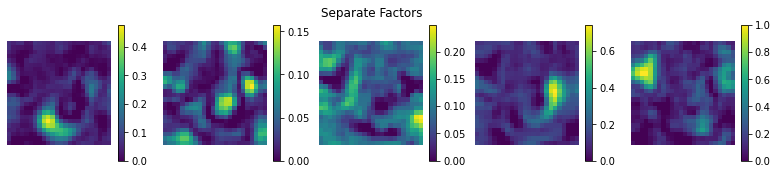

In [15]:
layer = "conv4_3"
bdr = 2
Ttsr = Ttsr_dict[layer]
cctsr = cctsr_dict[layer]
Ttsr_pp = rectify_tsr(Ttsr, mode="abs", thr=(-5, 5)) # abs
Hmat, Hmaps, Tcomponents, ccfactor = tsr_factorize(Ttsr_pp, cctsr, bdr=bdr, Nfactor=5)

In [7]:
VGG = models.vgg16()
VGG.requires_grad_(False).cuda().eval();

In [16]:
from FactorModels_lib import FactorRegr_Machine, predict_cmp
fact_model = FactorRegr_Machine(Nfactor=5, batchnorm=True, spatial_nonneg=True)
fact_model.register_hooks(VGG, [layer], netname="vgg16")
fact_model.init_model(img_dim=224, borderclip=bdr)

In [ ]:
fact_model.feat_trans[layer].weight.shape
# fact_model.sp_mask[layer].weight.shape

In [17]:
sp_weight = torch.from_numpy(np.transpose(Hmaps, [2,0,1]).reshape([1,-1])).float().cuda()
feat_weight = torch.from_numpy(ccfactor.T).unsqueeze(2).unsqueeze(3).float().cuda()
#%
fact_model.feat_trans[layer].weight.data = feat_weight
fact_model.feat_trans[layer].bias.data.zero_()
fact_model.sp_mask[layer].weight.data = sp_weight
fact_model.sp_mask[layer].bias.data.zero_()
fact_model.bn_layer[layer].eval()

BatchNorm2d(512, eps=0.01, momentum=0.1, affine=True, track_running_stats=True)

100%|██████████| 121/121 [00:02<00:00, 52.28it/s]


 Summary
Layer conv4_3: Corr 0.608 MSE 6259827.000


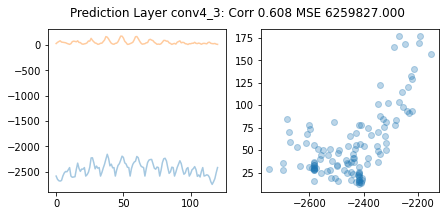

In [19]:
pred_scores = predict_cmp(VGG.features, fact_model, torch.from_numpy(score_vect).float(), imgfullpath_vect, imgloader=loadimg_preprocess, batchsize=25, summarystr="")

100%|██████████| 3525/3525 [01:05<00:00, 54.21it/s]


 Summary
Layer conv4_3: Corr -0.221 MSE 4771970.500


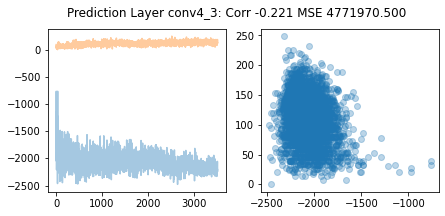

In [21]:
score_vect, imgfullpath_vect = load_score_mat(EStats, MStats, Expi, "Evol", wdws=[(50, 200)], stimdrive="S")#Manif_avg
pred_scores = predict_cmp(VGG.features, fact_model, torch.from_numpy(score_vect).float(), imgfullpath_vect, imgloader=loadimg_preprocess, batchsize=25, summarystr="")

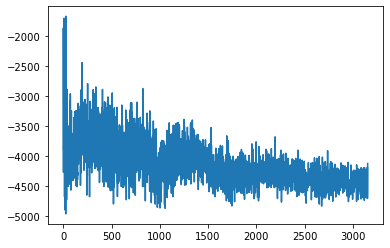

In [31]:
plt.plot(pred_scores["conv4_3"])
plt.show()

In [30]:
torch.cuda.empty_cache()
del VGG